In [1]:
from datetime import datetime
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from matplotlib.tri import Triangulation
import subprocess

from tqdm.notebook import tqdm

from utils import (
    get_mesh_files,
    load_data,
    advect_nodes,
    remesh,
    optimize_mesh,
    compute_mapping,
    get_area_ratio,
    resample_velocities
)

from remeshing import get_area

np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline

In [2]:
def remesh_docker(tria, fixed_nodes_idx):
    # Save mesh to file
    np.savez('mesh1.npz', x=tria.x, y=tria.y, t=tria.triangles, m=fixed_nodes_idx)
    container_name = "pymesh_remesh"

    # Check if the container is already running
    result = subprocess.run(
        f"docker ps --filter 'name={container_name}' --format '{{{{.Names}}}}'",
        shell=True, capture_output=True, text=True
    )
    running = container_name in result.stdout.strip().splitlines()

    if not running:
        # Remove any stopped container with the same name
        subprocess.call(f"docker rm {container_name}", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        # Start a new container in detached mode
        subprocess.call(
            f"docker run -d --rm --name {container_name} -v `pwd`:/tardis -w /tardis pymesh/pymesh tail -f /dev/null",
            shell=True
        )

    # Execute the script in the running container
    subprocess.call(
        f"docker exec {container_name} python runpymesh.py 13 50 > docker.log 2>&1",
        shell=True
    )
    # Run docker command
    #subprocess.call('docker run --rm -v `pwd`:/tardis -w /tardis pymesh/pymesh python runpymesh.py 13 50 > docker.log 2>&1', shell=True)

    # Load mesh from file
    with np.load('mesh2.npz') as data:
        x = data['x']
        y = data['y']
        t = data['t']
        m = data['m']
    return Triangulation(x, y, t), m



In [3]:
mesh_init_file = 'mesh_arctic_ease_25km_max7.npz'
xc = np.load(mesh_init_file)['xc']
yc = np.load(mesh_init_file)['yc']
mask = np.load(mesh_init_file)['mask']
mask_f = gaussian_filter(mask.astype(float), 1, truncate=1)

In [4]:
force = True
min_edge_length = 13
max_edge_length = 50
min_edge_angle = 15
min_triangles = 5
search_dist = 50
max_dist0 = 50
min_area = 20
max_mask_fix_node=0.15
max_mask_zero_speed=0.6

sid_dir = '/Users/antonk/Data/sia_sid_cdr_postproc'
lag_dir = '/Users/antonk/Data/sia/cdr_1991_2023/mesh'
ifiles = sorted(glob.glob(f'{sid_dir}/*/*npz'))[788:]

idates = [datetime.strptime(os.path.basename(ifile).split('-')[-1].split('.')[0], '%Y%m%d%H%M%S')
          for ifile in ifiles]
print(len(ifiles), idates[0], idates[-1])

307 2020-02-28 12:00:00 2020-12-30 12:00:00


In [5]:
# MOVE MESH
for ifile, idate in tqdm(zip(ifiles, idates), total=len(ifiles)):
    mesh_src_file, mesh_dst_file = get_mesh_files(idate, lag_dir, mesh_init_file)
    if os.path.exists(mesh_dst_file) and not force:
        continue
    u, v, tri0 = load_data(ifile, mesh_src_file)
    u0, v0, fixed_nodes_idx = resample_velocities(u, v, mask_f, xc, yc, tri0.x, tri0.y, max_mask_fix_node, max_mask_zero_speed)
    tri_a = advect_nodes(tri0, u0, v0, max_dist0)
    tri_r = remesh(tri_a, fixed_nodes_idx, min_area, min_edge_length, min_edge_angle, max_edge_length)
    tri_o = optimize_mesh(tri_a, tri_r, fixed_nodes_idx)
    src2dst, weights = compute_mapping(tri_a, tri_o, search_dist)
    area_ratio = get_area_ratio(tri0, tri_a, tri_o, src2dst, weights)

    tri_r_do, fixed_nodes_idx_do = remesh_docker(tri_a, fixed_nodes_idx)
    tri_o_do = optimize_mesh(tri_a, tri_r_do, fixed_nodes_idx_do)
    src2dst_do, weights_do = compute_mapping(tri_a, tri_o_do, search_dist)
    area_ratio_do = get_area_ratio(tri0, tri_a, tri_o_do, src2dst_do, weights_do)

    break

    print(f'Save mesh file to {mesh_dst_file}')
    np.savez(mesh_dst_file, x=tri_o.x.astype(np.float32), y=tri_o.y.astype(np.float32), t=tri_o.triangles, src2dst=src2dst, weights=weights.astype(np.float32), ar=area_ratio.astype(np.float32))


  0%|          | 0/307 [00:00<?, ?it/s]

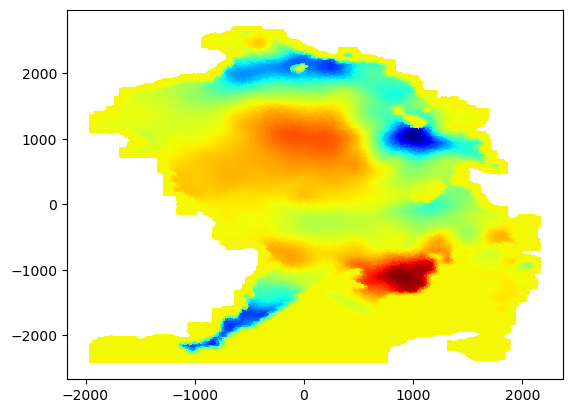

In [12]:
u0el = u0[tri0.triangles].mean(axis=1)
plt.tripcolor(tri_a, u0el, cmap='jet')

u0el_o = np.zeros(src2dst[:,1].max()+1)
np.add.at(u0el_o, src2dst[:,1], u0el[src2dst[:,0]] * weights)


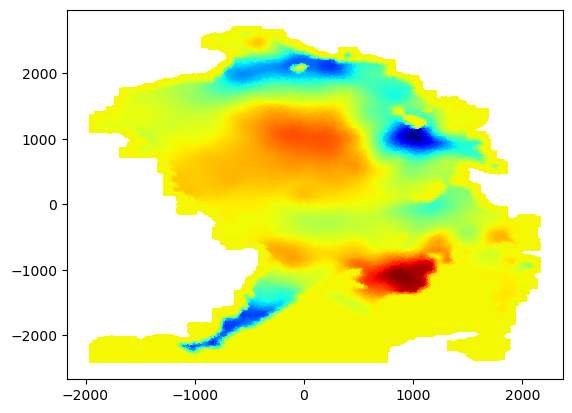

In [13]:
plt.tripcolor(tri_o, u0el_o, cmap='jet')

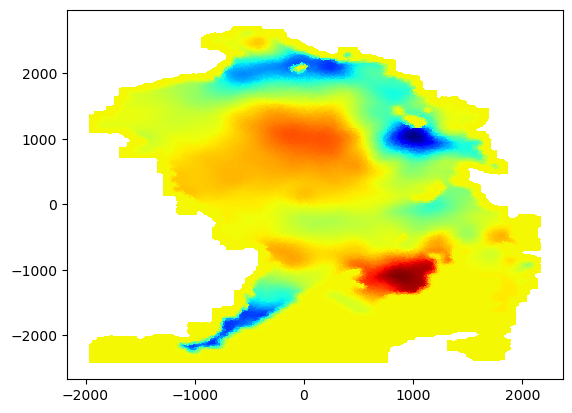

In [15]:
u0el_o_do = np.zeros(src2dst_do[:,1].max()+1)
np.add.at(u0el_o_do, src2dst_do[:,1], u0el[src2dst_do[:,0]] * weights_do)

plt.tripcolor(tri_o_do, u0el_o_do, cmap='jet')